# Auto Encoder

## Load Dataset

In [1]:
DATASET_NAME = 'dataset-5000'
TEST_DATASET_NAME = 'dataset-test'

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

from torch.utils.data import DataLoader, Dataset
from datasets import load_from_disk

class GeneratedDataset(Dataset):
    def __init__(self, name, transform=None):
        self.dataset_dict = load_from_disk(name)
        self.dataset = self.dataset_dict['train']
        self.transform = transform 
    
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]['image']
        if self.transform:
            image = self.transform(image)
        return image 
    
# Load and preprocess the dataset
transform = transforms.Compose([
    #transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

trainset = GeneratedDataset(DATASET_NAME, transform)
trainloader = DataLoader(trainset, batch_size=16, shuffle=True)

testset = GeneratedDataset(TEST_DATASET_NAME, transform)
testloader = DataLoader(testset, batch_size=16, shuffle=False)


## Define CNN based auto-encoder

- 64 * 64 * 3 image input = 12,288
- Cov3 with 32 channel, 3 * 3 * 3 * 32 = 864 parameters
- ReLU
- MaxPool -> 32 * 32 * 32 hidden state = 32768
- Cov3 with 64 channel, 32 * 3 * 3 * 64 = 18432 parameters
- ReLU
- MaxPool -> 16 * 16 * 64 hidden state = 16384
- Cov3 with 128 channel, 64 * 3 * 3 * 128 = 73728 parameters
- ReLU
- MaxPool -> 8 * 8 * 128 = 8192 hidden state
- Full connected 8192 -> **embedding size**

And the decoder works reversely.

In [2]:
# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, embedding_size=32):
        super(Autoencoder, self).__init__()
        self.embedding_size = embedding_size
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )
        self.fc1 = nn.Linear(8 * 8 * 128, self.embedding_size)  # Fully connected layer to get 32-length embedding

        # Decoder
        self.fc2 = nn.Linear(self.embedding_size, 8 * 8 * 128)  # Fully connected layer to reshape back to 8x8x128
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(32, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        encoded = encoded.view(encoded.size(0), -1)  # Flatten the tensor
        encoded = self.fc1(encoded)  # Get the embedding
        decoded = self.fc2(encoded)  # Reshape back to 8x8x128
        decoded = decoded.view(decoded.size(0), 128, 8, 8)
        decoded = self.decoder(decoded)
        return decoded, encoded

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

In [4]:
def train_model(embedding_size=32, learning_rate=1e-4, weight_decay=1e-5, num_epochs=20):
    # Initialize the model, loss function, and optimizer
    model = Autoencoder(embedding_size=embedding_size)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    # Arrays to store training and testing loss
    train_losses = []
    test_losses = []

    model = model.to(device)

    # Training the autoencoder
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for data in trainloader:
            inputs = data.to(device)
            outputs, _ = model(inputs)
            loss = criterion(outputs, inputs)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(trainloader)
        train_losses.append(train_loss)

        model.eval()
        test_loss = 0
        with torch.no_grad():
            for data in testloader:
                inputs = data.to(device)
                outputs, _ = model(inputs)
                loss = criterion(outputs, inputs)
                test_loss += loss.item()
        
        test_loss /= len(testloader)
        test_losses.append(test_loss)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
        scheduler.step()

    # Save the model
    # torch.save(model.state_dict(), 'autoencoder.pth')
    return model, train_losses, test_losses


In [5]:
import matplotlib.pyplot as plt

def plot_model(model, train_losses, test_losses):
    # Plot the training and testing loss
    plt.figure(figsize=(10,5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Testing Loss')
    plt.show()

    # Show some examples of reconstruction
    model.eval()
    with torch.no_grad():
        for i in range(5):  # Show 5 examples
            inputs = testset[i].unsqueeze(0)  # Add batch dimension
            inputs = inputs
            outputs, _ = model(inputs.to(device))
            outputs = outputs.to('cpu')
            
            plt.figure(figsize=(6,3))
            
            # Original Image
            plt.subplot(1,2,1)
            plt.imshow(inputs.squeeze().permute(1, 2, 0).numpy())
            plt.title('Original Image')
            
            # Reconstructed Image
            plt.subplot(1,2,2)
            plt.imshow(outputs.squeeze().permute(1, 2, 0).numpy())
            plt.title('Reconstructed Image')
            
            plt.show()

## Evaluation

Testing with embedding size of (down from 8192)
- 1024
- 512
- 256
- 128
- 64
- 32
- 16
- 8
- 4
- 2

Epoch [1/20], Train Loss: 0.3040, Test Loss: 0.2310
Epoch [2/20], Train Loss: 0.1532, Test Loss: 0.1435
Epoch [3/20], Train Loss: 0.1377, Test Loss: 0.1424
Epoch [4/20], Train Loss: 0.1348, Test Loss: 0.1380
Epoch [5/20], Train Loss: 0.1326, Test Loss: 0.1363
Epoch [6/20], Train Loss: 0.1301, Test Loss: 0.1332
Epoch [7/20], Train Loss: 0.1281, Test Loss: 0.1319
Epoch [8/20], Train Loss: 0.1263, Test Loss: 0.1304
Epoch [9/20], Train Loss: 0.1249, Test Loss: 0.1297
Epoch [10/20], Train Loss: 0.1237, Test Loss: 0.1283
Epoch [11/20], Train Loss: 0.1226, Test Loss: 0.1269
Epoch [12/20], Train Loss: 0.1218, Test Loss: 0.1268
Epoch [13/20], Train Loss: 0.1212, Test Loss: 0.1257
Epoch [14/20], Train Loss: 0.1207, Test Loss: 0.1252
Epoch [15/20], Train Loss: 0.1203, Test Loss: 0.1250
Epoch [16/20], Train Loss: 0.1199, Test Loss: 0.1247
Epoch [17/20], Train Loss: 0.1196, Test Loss: 0.1246
Epoch [18/20], Train Loss: 0.1195, Test Loss: 0.1244
Epoch [19/20], Train Loss: 0.1192, Test Loss: 0.1244
Ep

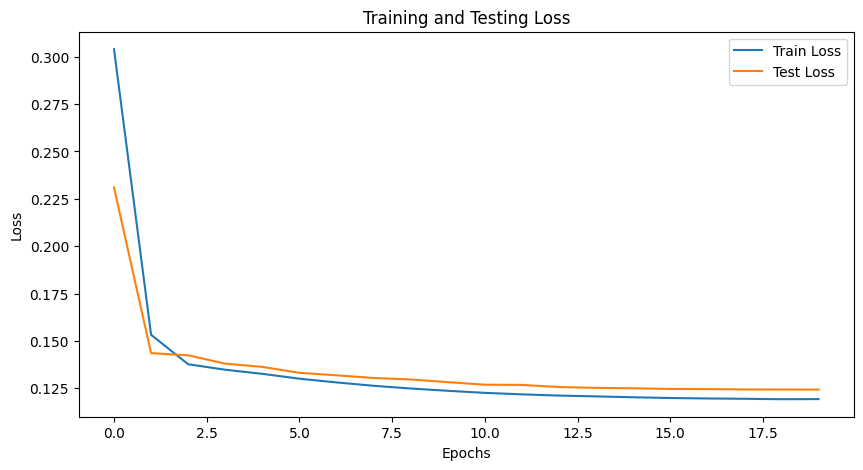

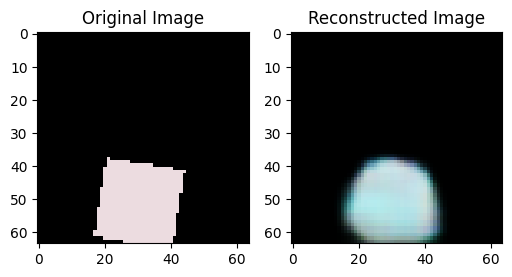

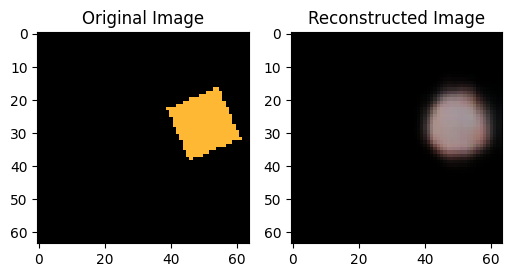

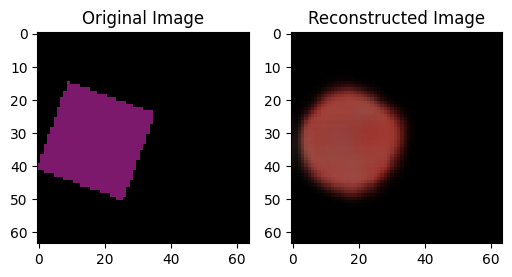

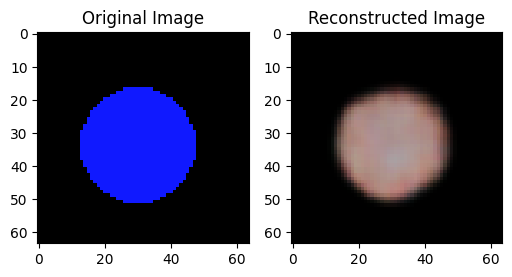

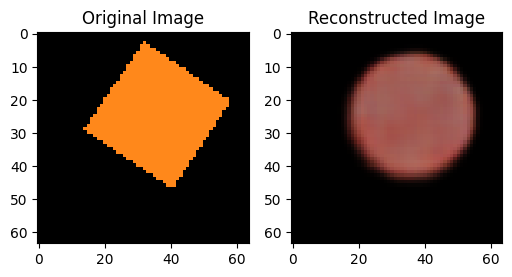

In [6]:
model, train_losses, test_losses = train_model(4)
plot_model(model, train_losses, test_losses)

Epoch [1/20], Train Loss: 0.2999, Test Loss: 0.2207
Epoch [2/20], Train Loss: 0.1524, Test Loss: 0.1447
Epoch [3/20], Train Loss: 0.1378, Test Loss: 0.1402
Epoch [4/20], Train Loss: 0.1348, Test Loss: 0.1377
Epoch [5/20], Train Loss: 0.1317, Test Loss: 0.1337
Epoch [6/20], Train Loss: 0.1273, Test Loss: 0.1289
Epoch [7/20], Train Loss: 0.1214, Test Loss: 0.1205
Epoch [8/20], Train Loss: 0.1128, Test Loss: 0.1139
Epoch [9/20], Train Loss: 0.1078, Test Loss: 0.1099
Epoch [10/20], Train Loss: 0.1056, Test Loss: 0.1084
Epoch [11/20], Train Loss: 0.1041, Test Loss: 0.1073
Epoch [12/20], Train Loss: 0.1029, Test Loss: 0.1063
Epoch [13/20], Train Loss: 0.1018, Test Loss: 0.1056
Epoch [14/20], Train Loss: 0.1010, Test Loss: 0.1046
Epoch [15/20], Train Loss: 0.1003, Test Loss: 0.1042
Epoch [16/20], Train Loss: 0.0999, Test Loss: 0.1036
Epoch [17/20], Train Loss: 0.0994, Test Loss: 0.1034
Epoch [18/20], Train Loss: 0.0991, Test Loss: 0.1031
Epoch [19/20], Train Loss: 0.0990, Test Loss: 0.1030
Ep

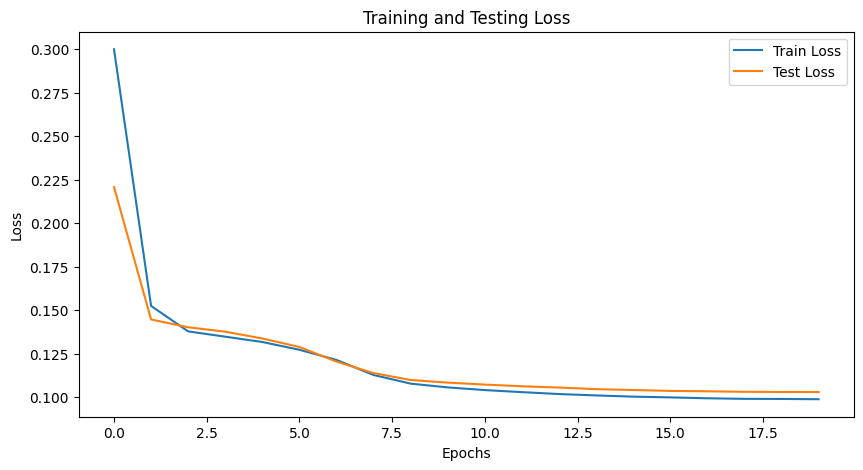

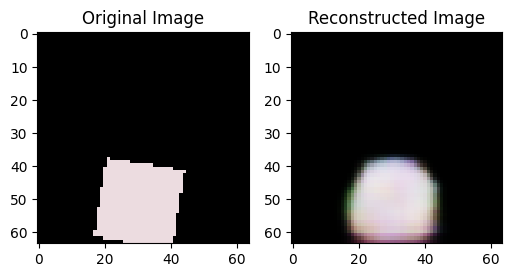

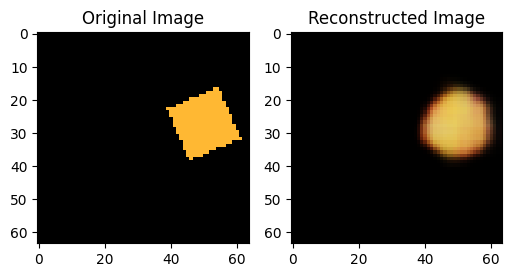

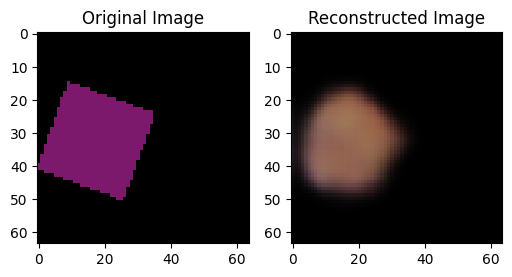

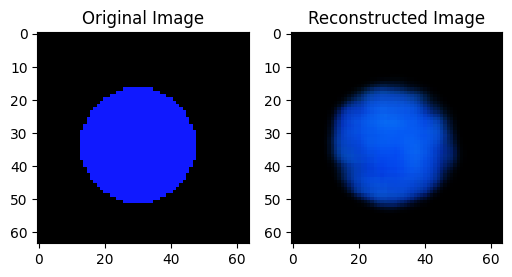

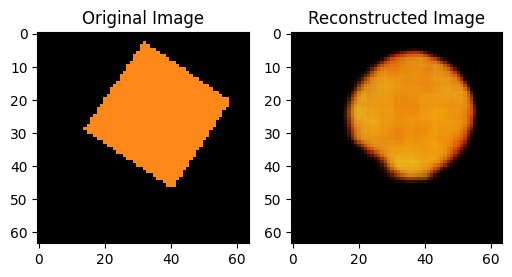

In [7]:
model, train_losses, test_losses = train_model(8)
plot_model(model, train_losses, test_losses)

Epoch [1/20], Train Loss: 0.2896, Test Loss: 0.1581
Epoch [2/20], Train Loss: 0.1410, Test Loss: 0.1415
Epoch [3/20], Train Loss: 0.1345, Test Loss: 0.1372
Epoch [4/20], Train Loss: 0.1297, Test Loss: 0.1307
Epoch [5/20], Train Loss: 0.1229, Test Loss: 0.1225
Epoch [6/20], Train Loss: 0.1133, Test Loss: 0.1117
Epoch [7/20], Train Loss: 0.1065, Test Loss: 0.1080
Epoch [8/20], Train Loss: 0.1034, Test Loss: 0.1053
Epoch [9/20], Train Loss: 0.1010, Test Loss: 0.1037
Epoch [10/20], Train Loss: 0.0993, Test Loss: 0.1021
Epoch [11/20], Train Loss: 0.0978, Test Loss: 0.1011
Epoch [12/20], Train Loss: 0.0964, Test Loss: 0.0997
Epoch [13/20], Train Loss: 0.0953, Test Loss: 0.0996
Epoch [14/20], Train Loss: 0.0944, Test Loss: 0.0983
Epoch [15/20], Train Loss: 0.0935, Test Loss: 0.0977
Epoch [16/20], Train Loss: 0.0929, Test Loss: 0.0971
Epoch [17/20], Train Loss: 0.0924, Test Loss: 0.0970
Epoch [18/20], Train Loss: 0.0921, Test Loss: 0.0966
Epoch [19/20], Train Loss: 0.0919, Test Loss: 0.0966
Ep

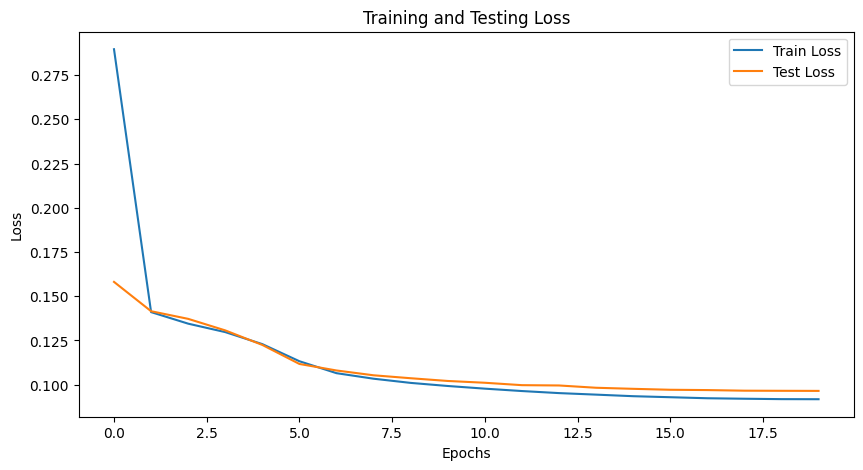

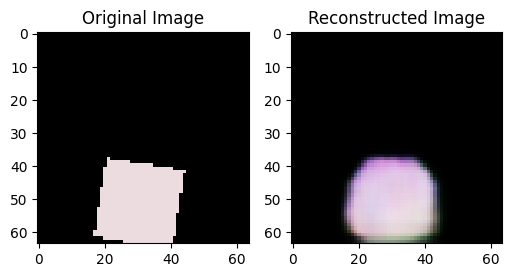

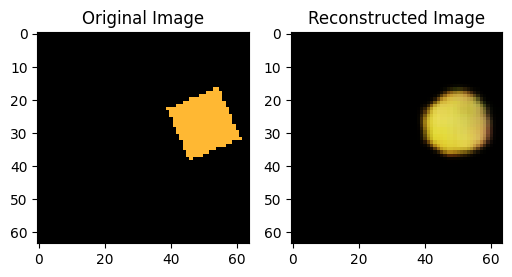

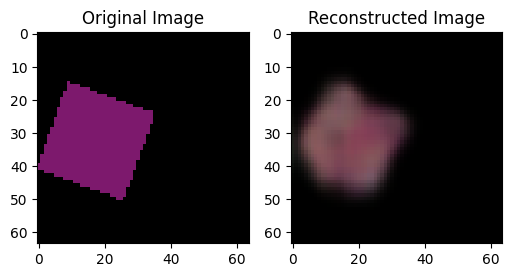

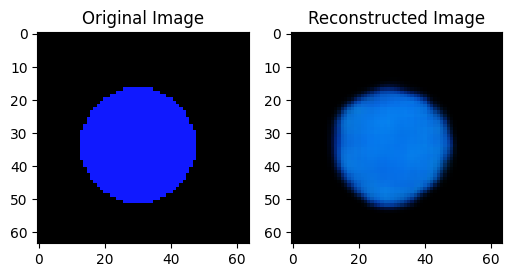

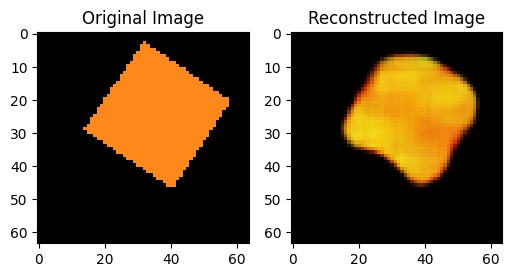

In [8]:
model, train_losses, test_losses = train_model(16)
plot_model(model, train_losses, test_losses)

Epoch [1/20], Train Loss: 0.2761, Test Loss: 0.1515
Epoch [2/20], Train Loss: 0.1392, Test Loss: 0.1403
Epoch [3/20], Train Loss: 0.1329, Test Loss: 0.1354
Epoch [4/20], Train Loss: 0.1264, Test Loss: 0.1273
Epoch [5/20], Train Loss: 0.1179, Test Loss: 0.1150
Epoch [6/20], Train Loss: 0.1079, Test Loss: 0.1080
Epoch [7/20], Train Loss: 0.1036, Test Loss: 0.1056
Epoch [8/20], Train Loss: 0.1008, Test Loss: 0.1043
Epoch [9/20], Train Loss: 0.0984, Test Loss: 0.1010
Epoch [10/20], Train Loss: 0.0960, Test Loss: 0.0991
Epoch [11/20], Train Loss: 0.0937, Test Loss: 0.0969
Epoch [12/20], Train Loss: 0.0914, Test Loss: 0.0949
Epoch [13/20], Train Loss: 0.0893, Test Loss: 0.0933
Epoch [14/20], Train Loss: 0.0874, Test Loss: 0.0920
Epoch [15/20], Train Loss: 0.0860, Test Loss: 0.0907
Epoch [16/20], Train Loss: 0.0851, Test Loss: 0.0900
Epoch [17/20], Train Loss: 0.0846, Test Loss: 0.0896
Epoch [18/20], Train Loss: 0.0841, Test Loss: 0.0891
Epoch [19/20], Train Loss: 0.0838, Test Loss: 0.0890
Ep

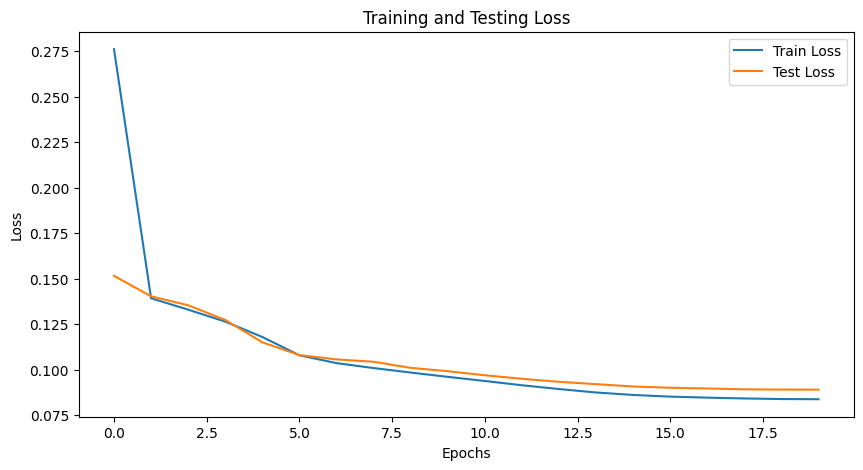

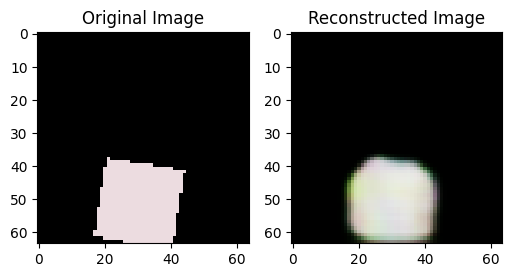

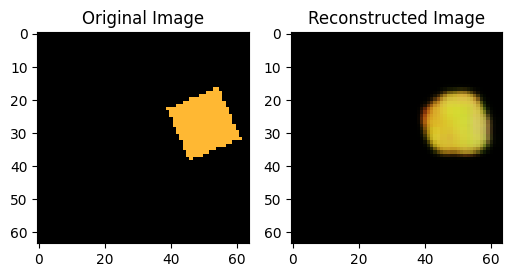

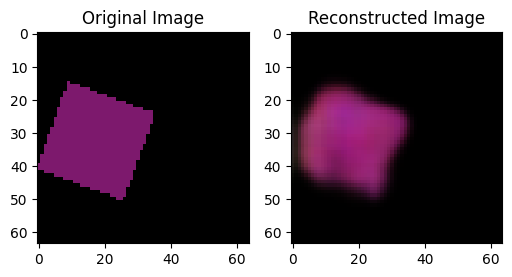

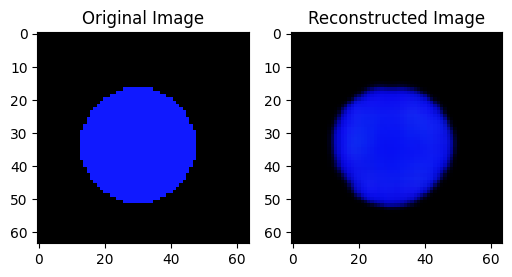

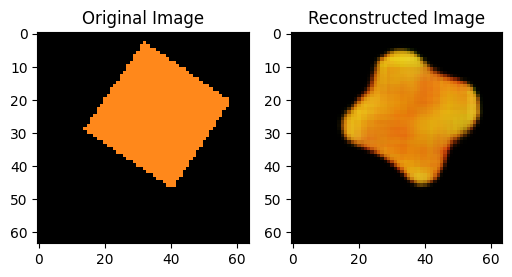

In [9]:
model, train_losses, test_losses = train_model(32)
plot_model(model, train_losses, test_losses)

Epoch [1/20], Train Loss: 0.2794, Test Loss: 0.1511
Epoch [2/20], Train Loss: 0.1393, Test Loss: 0.1392
Epoch [3/20], Train Loss: 0.1332, Test Loss: 0.1350
Epoch [4/20], Train Loss: 0.1276, Test Loss: 0.1296
Epoch [5/20], Train Loss: 0.1194, Test Loss: 0.1151
Epoch [6/20], Train Loss: 0.1072, Test Loss: 0.1081
Epoch [7/20], Train Loss: 0.1025, Test Loss: 0.1048
Epoch [8/20], Train Loss: 0.0995, Test Loss: 0.1030
Epoch [9/20], Train Loss: 0.0969, Test Loss: 0.1000
Epoch [10/20], Train Loss: 0.0940, Test Loss: 0.0968
Epoch [11/20], Train Loss: 0.0909, Test Loss: 0.0941
Epoch [12/20], Train Loss: 0.0880, Test Loss: 0.0914
Epoch [13/20], Train Loss: 0.0858, Test Loss: 0.0900
Epoch [14/20], Train Loss: 0.0846, Test Loss: 0.0893
Epoch [15/20], Train Loss: 0.0836, Test Loss: 0.0884
Epoch [16/20], Train Loss: 0.0830, Test Loss: 0.0879
Epoch [17/20], Train Loss: 0.0825, Test Loss: 0.0877
Epoch [18/20], Train Loss: 0.0822, Test Loss: 0.0874
Epoch [19/20], Train Loss: 0.0820, Test Loss: 0.0872
Ep

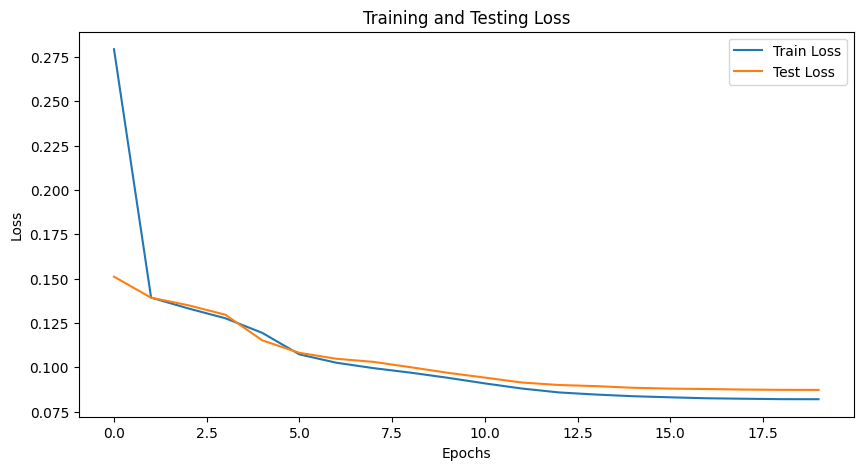

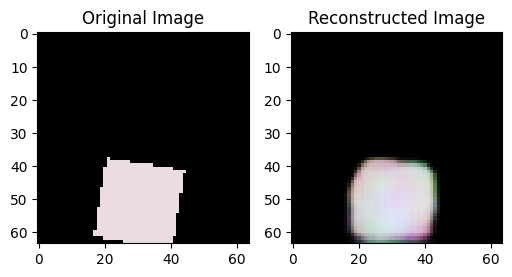

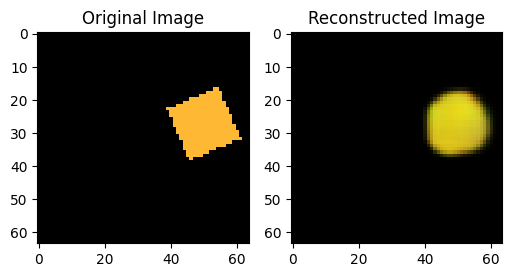

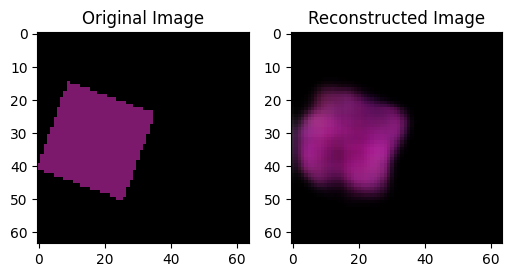

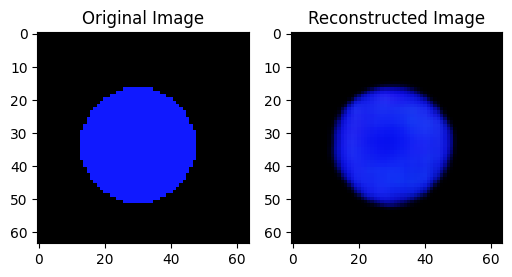

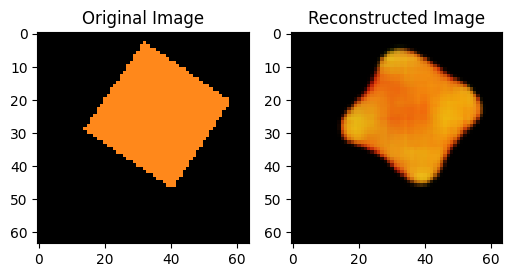

In [10]:
model, train_losses, test_losses = train_model(64)
plot_model(model, train_losses, test_losses)